In [ ]:
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing
from sklearn.utils import shuffle
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
import cv2
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from skimage import io, color, feature, filters, exposure
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Eye extraction implementation
It is necessary to perform eye extraction before loading the dataset so that, prior to resizing, the images can be normalized in terms of aspect ratio.

In [ ]:
def eye_extraction(image: list) -> list:
  '''
  Calculates the borders of an eye so that the background can be deleted.
  Also gets converted from RGB to a grayscale image.

  Args:
    image (list): 3D matrix containing information about the image.

  Returns:
    list: A list containing 4 coordiantes of borders of the eye.
  '''
  image = rgb2gray(image)
  h, w = image.shape
  image = image * 255
  found_pixel = False
  threshold = 30
  x1, y1, x2, y2 = 0, 0, 0 , 0
  for i in range(h):
      for j in range(w):
        if image[i][j] > threshold:
            y1, found_pixel = i, True
            break
      if found_pixel:
          break

  found_pixel = False

  for j in range(w):
      for i in range(h):
          if image[i][j] > threshold:
            x1, found_pixel = j, True
            break
      if found_pixel:
          break


  found_pixel = False
  for i in range(h -1, -1, -1):
      for j in range(w -1, -1, -1):
          if image[i][j] > threshold:
            y2, found_pixel = i, True
            break
      if found_pixel:
          break


  found_pixel = False
  for j in range(w - 1, -1, -1):
      for i in range(h - 1, -1, -1):
          if image[i][j] > threshold:
              x2, found_pixel = j, True
              break
      if found_pixel:
          break

  return [x1, y1, x2, y2]

def rescale_image(coordinates: list, image: list) -> list:
  '''
  Rescales the image from the original to given coordinates.

  Args:
    coordinates (list): A list containing pairs of coordinates (x1, y1, x2, y2).
    image (list): A 2D list representing the image.

  Returns:
    list: The rescaled image.
  '''
  image = rgb2gray(image)
  x1, y1, x2, y2 = coordinates
  conv_img = np.zeros((y2 - y1, x2 - x1))
  for i in range(x2 - x1):
    for j in range(y2 - y1):
      conv_img[j][i] = image[j + y1][i + x1]
  return conv_img

Image edit example

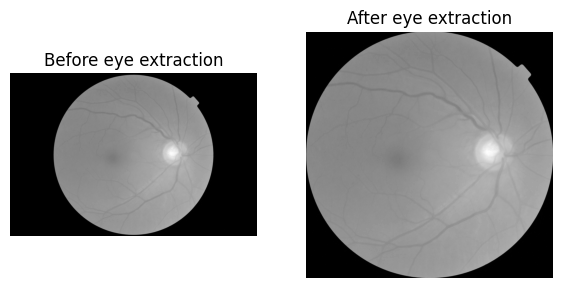

In [ ]:
img = Image.open("/content/drive/MyDrive/Datasets/Eye Diseases/glaucoma/Glaucoma_101.png")
img = np.array(img)
coordinates = eye_extraction(img)
converted_image = rescale_image(coordinates, img)
fig, ax = plt.subplots(1, 2, figsize=(7, 4))
ax[0].imshow(rgb2gray(img), cmap='gray')
ax[0].set_title('Before eye extraction')
ax[1].imshow(converted_image, cmap='gray')
ax[1].set_title('After eye extraction')
for a in ax:
    a.axis('off')
plt.show()

# Image loading

In [ ]:
data_folder = "/content/drive/MyDrive/Datasets/Eye Diseases"

class_names = os.listdir(data_folder)

data = []
labels = []

for class_name in class_names:
    class_folder = os.path.join(data_folder, class_name)
    for filename in os.listdir(class_folder):
        img_path = os.path.join(class_folder, filename)
        img = Image.open(img_path)
        img = img.resize((224, 224))
        img_array = np.array(img)
        data.append(img_array)
        labels.append(class_name)

Converting images into train, test and validation sets.



In [ ]:
data, labels = shuffle(data, labels, random_state=42)
le = preprocessing.LabelEncoder()
labels_encoded = le.fit_transform(labels)

train_data, test_data_temp, train_labels, test_labels_temp = train_test_split(data, labels_encoded, test_size=0.2, random_state=42)
test_data, val_data, test_labels, val_labels = train_test_split(test_data_temp, test_labels_temp, test_size=0.5, random_state=42)

train_data = np.array(train_data)
test_data = np.array(test_data)
val_data = np.array(val_data)
y_train = np.array(train_labels)
y_test = np.array(test_labels)
y_val = np.array(val_labels)
del data, img_array, img, img_path, labels

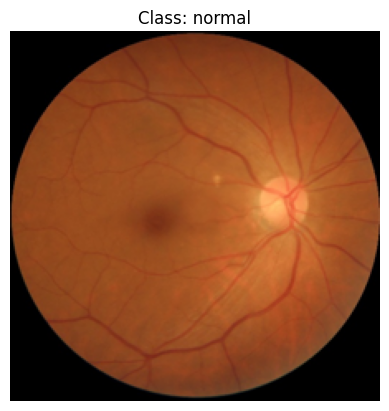

In [ ]:
original_label = le.inverse_transform([y_train[0]])[0]
plt.imshow(train_data[0])
plt.title(f"Class: {original_label}")
plt.axis('off');

RGB to grayscale conversion

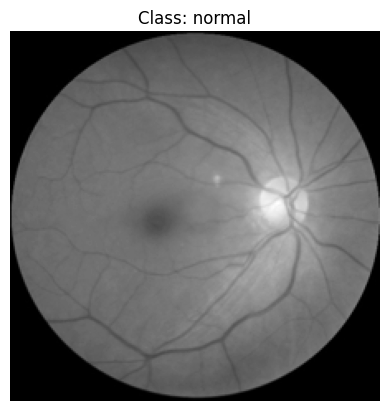

In [ ]:
plt.imshow(rgb2gray(train_data[0]), cmap='gray')
plt.title(f"Class: {original_label}")
plt.axis('off');

In [ ]:
converted_train_data = []
converted_test_data = []
converted_val_data = []

for image in train_data:
  coordinates = eye_extraction(image)
  im = rescale_image(coordinates, image)
  im = cv2.resize(im, (224,224))
  converted_train_data.append(im)

for image in test_data:
  coordinates = eye_extraction(image)
  im = rescale_image(coordinates, image)
  im = cv2.resize(im, (224,224))
  converted_test_data.append(im)

for image in val_data:
  coordinates = eye_extraction(image)
  im = rescale_image(coordinates, image)
  im = cv2.resize(im, (224,224))
  converted_val_data.append(im)

del train_data, test_data, val_data

Example of eye extraction

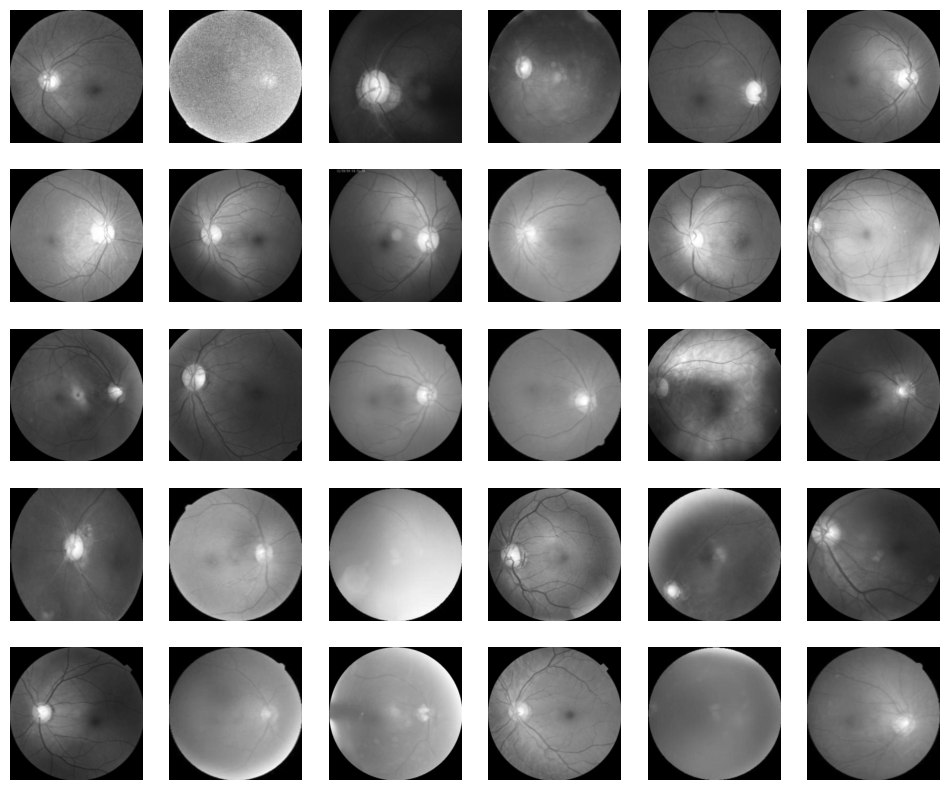

In [ ]:
fig, axes = plt.subplots(5, 6, figsize=(12, 10))

for i in range(30):
    ax = axes[i // 6, i % 6]
    ax.imshow(converted_test_data[i], cmap='gray')
    ax.axis('off')

plt.show()

# Feature extraction

In [ ]:
scaler = StandardScaler()
# scaler = MinMaxScaler()

## Image histogram

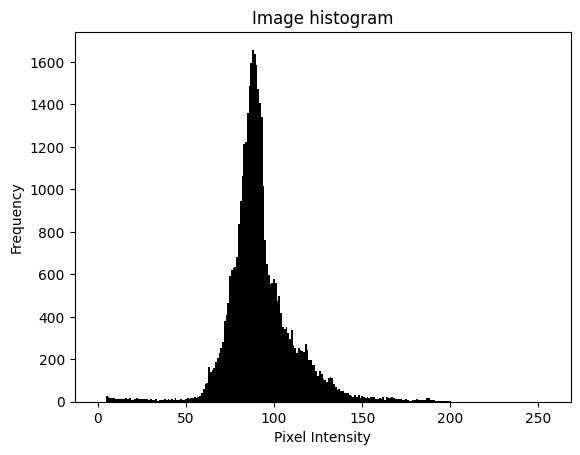

In [ ]:
hist = np.histogram(converted_train_data[0], bins=256, range=(0, 1))[0]
hist[:5] = 0
plt.bar(range(256), hist, width=1.0, color='black')
plt.title('Image histogram')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

Calculating histogram values for every image and deleting black background values.

In [ ]:
def hist_dataset(train, test, val):
  hist_train_data = []
  hist_test_data = []
  hist_val_data = []

  datasets = [converted_train_data, converted_test_data, converted_val_data]
  hist_datasets = [hist_train_data, hist_test_data, hist_val_data]

  for dataset, hist_data in zip(datasets, hist_datasets):
      for image in dataset:
          hist = np.histogram(image, bins=256, range=(0, 1))[0]
          hist[:5] = 0
          hist_data.append(hist)
  return scaler.fit_transform(hist_train_data), scaler.fit_transform(hist_test_data), scaler.fit_transform(hist_val_data)

## Local binary pattern

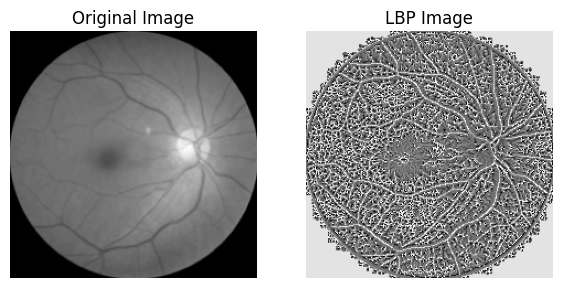

In [ ]:
num_points = 8
radius = 1
lbp = feature.local_binary_pattern(converted_train_data[0], num_points, radius, method="uniform")
fig, ax = plt.subplots(1, 2, figsize=(7, 4))
ax[0].imshow(converted_train_data[0], cmap='gray')
ax[0].set_title('Original Image')
ax[1].imshow(lbp, cmap='gray')
ax[1].set_title('LBP Image')
for a in ax:
    a.axis('off')
plt.show()

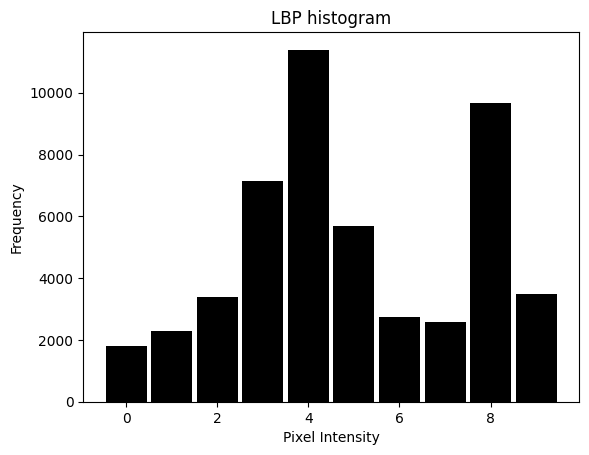

In [ ]:
lbp = feature.local_binary_pattern(converted_train_data[0], num_points, radius, method="uniform")
hist, _ = np.histogram(lbp, bins=np.arange(0, num_points + 3), range=(0, num_points + 2))
plt.bar(range(len(hist)), hist, width=.9, color='black')
plt.title('LBP histogram')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

In [ ]:
def convert_to_lbp(images: list, num_points: int, radius: int, method: str = "uniform") -> list:
  '''
  Converts a list of images to local binary pattern values and creates a histogram out of them.

  Args:
    images (list): A list of images.
    num_points (int): Number of circularly symmetric neighbor set points.
    radius (int): Radius of circle.
    method (str): Method to determine the pattern.

  Returns:
    list: A list containing histograms of lbp values of an image.
  '''
  hists = []
  for image in images:
    lbp = feature.local_binary_pattern(image, num_points, radius, method=method)
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, num_points + 3), range=(0, num_points + 2))
    hists.append(hist)
  return hists

The numbers present in each histogram are very high so scaling them might be a good practice before sending them to the model.

In [ ]:
def lbp_dataset(train, test, val):
  lbp_train = convert_to_lbp(converted_train_data, 8, 1)
  lbp_test = convert_to_lbp(converted_test_data, 8, 1)
  lbp_val = convert_to_lbp(converted_val_data, 8, 1)
  return scaler.fit_transform(lbp_train), scaler.fit_transform(lbp_test), scaler.fit_transform(lbp_val)

In [ ]:
lbps = convert_to_lbp(converted_train_data, 8, 1)

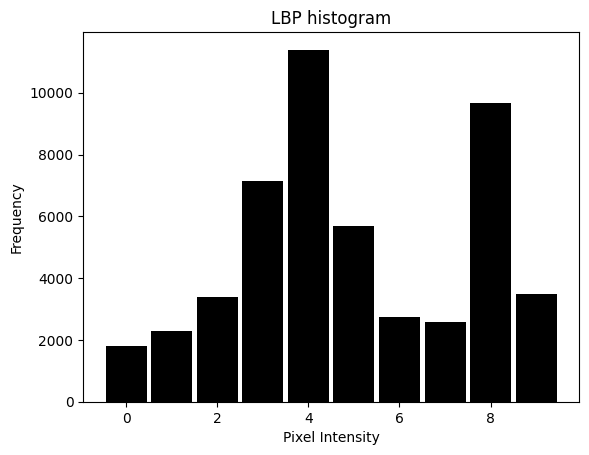

In [ ]:
plt.bar(range(len(lbps[0])), lbps[0], width=.9, color='black')
plt.title('LBP histogram')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

## PCA

In [ ]:
def pca_dataset(train, test, val):
  n_components = 30
  conv_train_data_flat = np.array(converted_train_data).reshape(len(converted_train_data), -1)
  conv_val_data_flat = np.array(converted_val_data).reshape(len(converted_val_data), -1)
  conv_test_data_flat = np.array(converted_test_data).reshape(len(converted_test_data), -1)
  pca = PCA(n_components=n_components)
  X_train_pca = pca.fit_transform(conv_train_data_flat)
  X_val_pca = pca.transform(conv_val_data_flat)
  X_test_pca = pca.transform(conv_test_data_flat)

  del conv_train_data_flat, conv_val_data_flat, conv_test_data_flat
  return scaler.fit_transform(X_train_pca), scaler.fit_transform(X_test_pca), scaler.fit_transform(X_val_pca)

PCA visualization

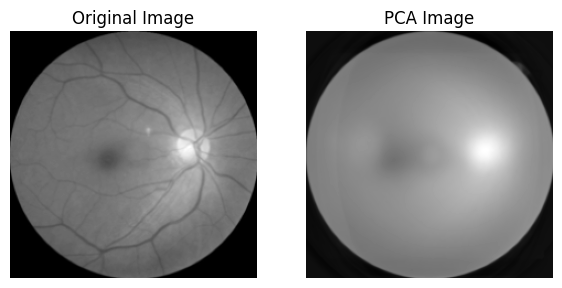

In [ ]:
reconstructed_data = pca.inverse_transform(X_train_pca)
reconstructed_images = reconstructed_data.reshape(-1 , 224,224)
fig, ax = plt.subplots(1, 2, figsize=(7, 4))
ax[0].imshow(converted_train_data[0], cmap='gray')
ax[0].set_title('Original Image')
ax[1].imshow(reconstructed_images[0], cmap='gray')
ax[1].set_title('PCA Image')
for a in ax:
    a.axis('off')
plt.show()

# Sobel

In [ ]:
def sobel_dataset(train, test, val):
  sobel = lambda image: filters.sobel(image)
  conv_train_data_flat = np.array(train).reshape(len(train), -1)
  conv_val_data_flat = np.array(val).reshape(len(val), -1)
  conv_test_data_flat = np.array(test).reshape(len(test), -1)
  X_train_sobel = [sobel(image) for image in conv_train_data_flat]
  X_test_sobel = [sobel(image) for image in conv_test_data_flat]
  X_val_sobel = [sobel(image) for image in conv_val_data_flat]
  del conv_train_data_flat, conv_test_data_flat, conv_val_data_flat
  return X_train_sobel, X_test_sobel, X_val_sobel

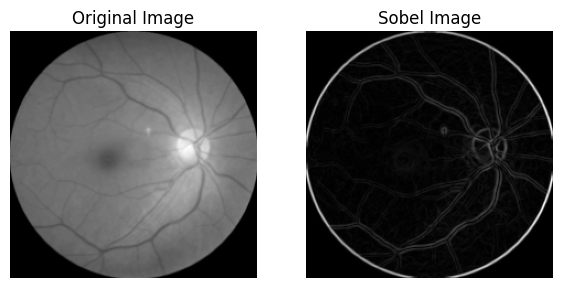

In [ ]:
sobel = lambda image: filters.sobel(image)
fig, ax = plt.subplots(1, 2, figsize=(7, 4))
ax[0].imshow(converted_train_data[0], cmap='gray')
ax[0].set_title('Original Image')
ax[1].imshow(sobel(converted_train_data[0]), cmap='gray')
ax[1].set_title('Sobel Image')
for a in ax:
    a.axis('off')
plt.show()

## Classification

In [ ]:
def train_classifier(classifier, param_grid, X_train, y_train):
    grid_search = GridSearchCV(classifier, param_grid, cv=3, verbose=2)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    return best_model, grid_search.best_params_

In [ ]:
def evaluate(classifiers):
  for classifier, param_grid in classifiers:
    best_model, best_params = train_classifier(classifier, param_grid, X_train, y_train)
    y_pred = best_model.predict(X_val)

    print(f"{classifier.__class__.__name__}")
    print("Best Parameters:", best_params)
    print(classification_report(y_val, y_pred, target_names=le.classes_, digits=4))
    sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, xticklabels=le.classes_, yticklabels=le.classes_)
    plt.show()

In [ ]:
svm_param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
rf_param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
knn_param_grid = {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}
adaboost_param_grid = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1.0]}

classifiers = [
    (SVC(), svm_param_grid),
    (RandomForestClassifier(), rf_param_grid),
    (KNeighborsClassifier(), knn_param_grid),
    (AdaBoostClassifier(), adaboost_param_grid)
]

SVC
Best Parameters: {'C': 10, 'kernel': 'rbf'}
                      precision    recall  f1-score   support

            cataract     0.7965    0.8036    0.8000       112
diabetic_retinopathy     0.9358    0.8644    0.8987       118
            glaucoma     0.6667    0.6452    0.6557        93
              normal     0.6847    0.7600    0.7204       100

            accuracy                         0.7754       423
           macro avg     0.7709    0.7683    0.7687       423
        weighted avg     0.7804    0.7754    0.7770       423



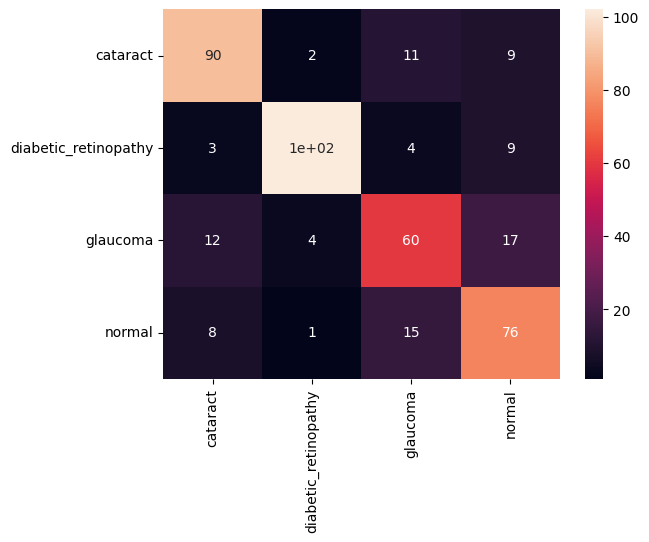

RandomForestClassifier
Best Parameters: {'max_depth': None, 'n_estimators': 200}
                      precision    recall  f1-score   support

            cataract     0.8113    0.7679    0.7890       112
diabetic_retinopathy     0.9333    0.8305    0.8789       118
            glaucoma     0.6706    0.6129    0.6404        93
              normal     0.5984    0.7600    0.6696       100

            accuracy                         0.7494       423
           macro avg     0.7534    0.7428    0.7445       423
        weighted avg     0.7641    0.7494    0.7532       423



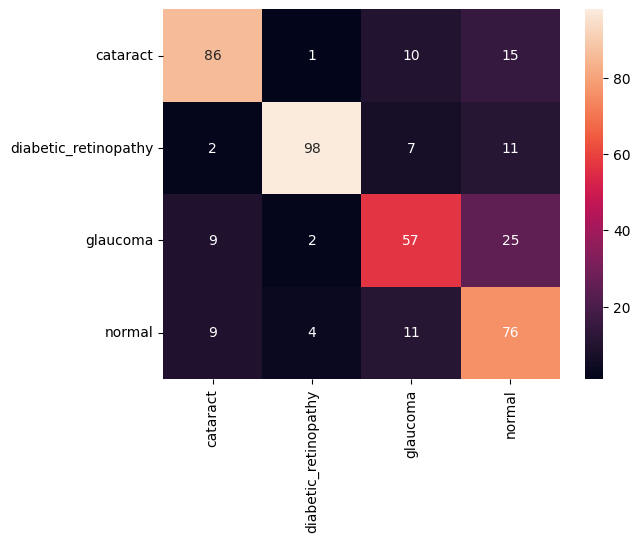

KNeighborsClassifier
Best Parameters: {'n_neighbors': 3, 'weights': 'distance'}
                      precision    recall  f1-score   support

            cataract     0.7667    0.8214    0.7931       112
diabetic_retinopathy     0.8850    0.8475    0.8658       118
            glaucoma     0.6197    0.4731    0.5366        93
              normal     0.5966    0.7100    0.6484       100

            accuracy                         0.7258       423
           macro avg     0.7170    0.7130    0.7110       423
        weighted avg     0.7272    0.7258    0.7228       423



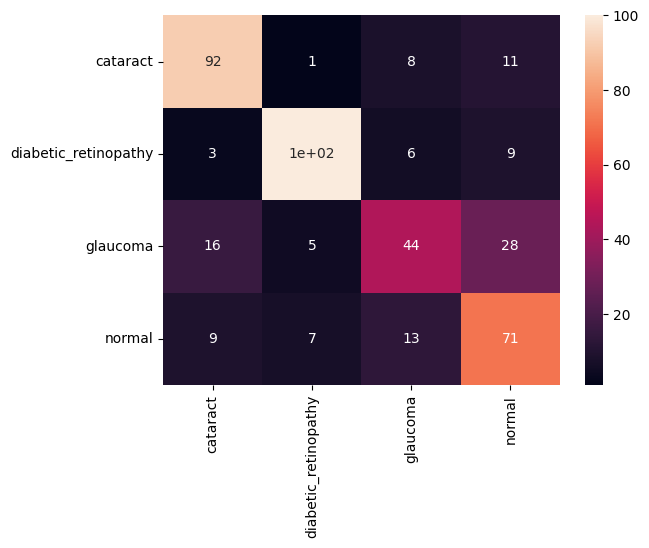

AdaBoostClassifier
Best Parameters: {'learning_rate': 1.0, 'n_estimators': 200}
                      precision    recall  f1-score   support

            cataract     0.6822    0.6518    0.6667       112
diabetic_retinopathy     0.9057    0.8136    0.8571       118
            glaucoma     0.5143    0.5806    0.5455        93
              normal     0.4667    0.4900    0.4780       100

            accuracy                         0.6430       423
           macro avg     0.6422    0.6340    0.6368       423
        weighted avg     0.6567    0.6430    0.6486       423



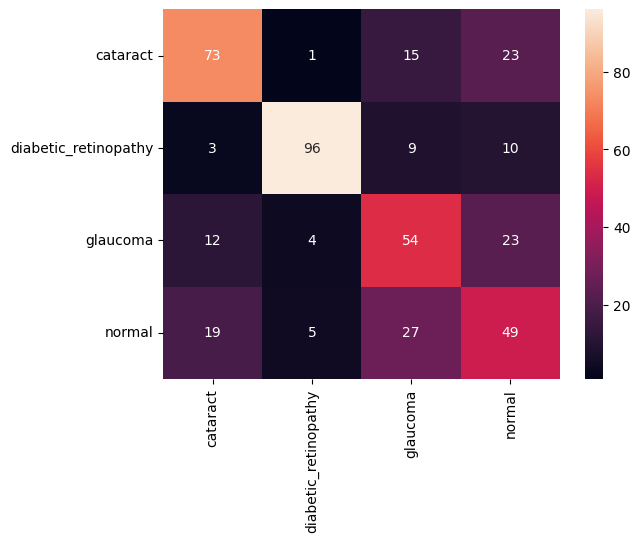

In [ ]:
del X_train, X_test, X_val
X_train, X_test, X_val = pca_dataset(converted_train_data, converted_test_data, converted_val_data)
evaluate(classifiers)

SVC
Best Parameters: {'C': 10, 'kernel': 'rbf'}
                      precision    recall  f1-score   support

            cataract     0.7069    0.7321    0.7193       112
diabetic_retinopathy     0.7674    0.5593    0.6471       118
            glaucoma     0.6027    0.4731    0.5301        93
              normal     0.4257    0.6300    0.5081       100

            accuracy                         0.6028       423
           macro avg     0.6257    0.5986    0.6011       423
        weighted avg     0.6344    0.6028    0.6076       423



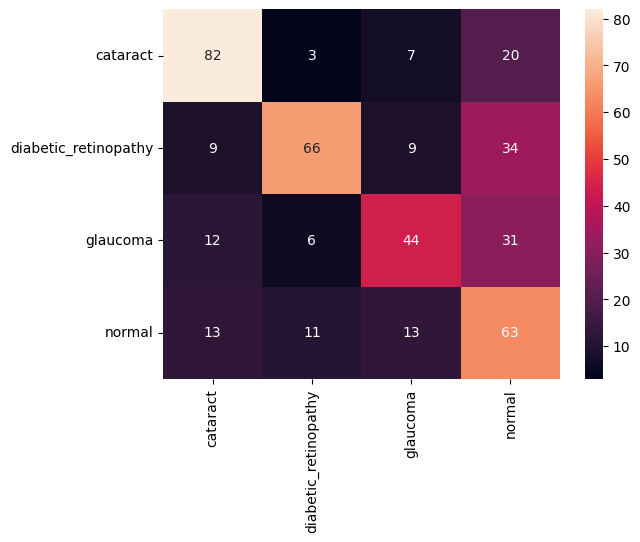

RandomForestClassifier
Best Parameters: {'max_depth': None, 'n_estimators': 200}
                      precision    recall  f1-score   support

            cataract     0.9048    0.1696    0.2857       112
diabetic_retinopathy     0.3070    0.8559    0.4519       118
            glaucoma     0.7250    0.3118    0.4361        93
              normal     0.3333    0.1100    0.1654       100

            accuracy                         0.3783       423
           macro avg     0.5675    0.3619    0.3348       423
        weighted avg     0.5634    0.3783    0.3367       423



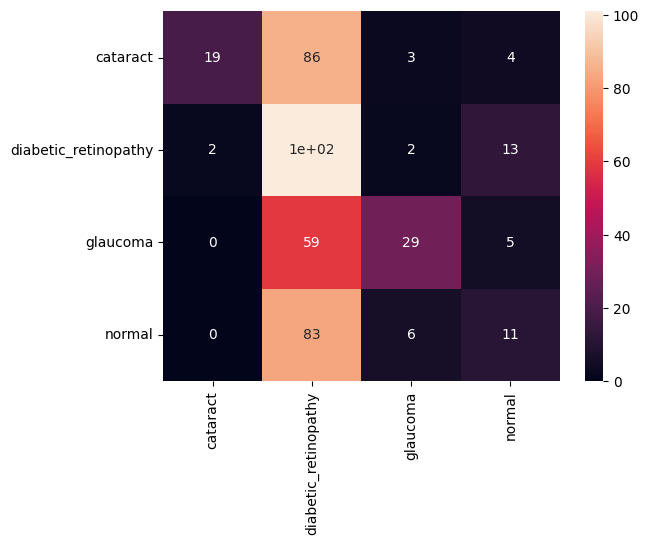

KNeighborsClassifier
Best Parameters: {'n_neighbors': 3, 'weights': 'distance'}
                      precision    recall  f1-score   support

            cataract     0.6870    0.7054    0.6960       112
diabetic_retinopathy     0.5437    0.4746    0.5068       118
            glaucoma     0.4836    0.6344    0.5488        93
              normal     0.4217    0.3500    0.3825       100

            accuracy                         0.5414       423
           macro avg     0.5340    0.5411    0.5335       423
        weighted avg     0.5396    0.5414    0.5368       423



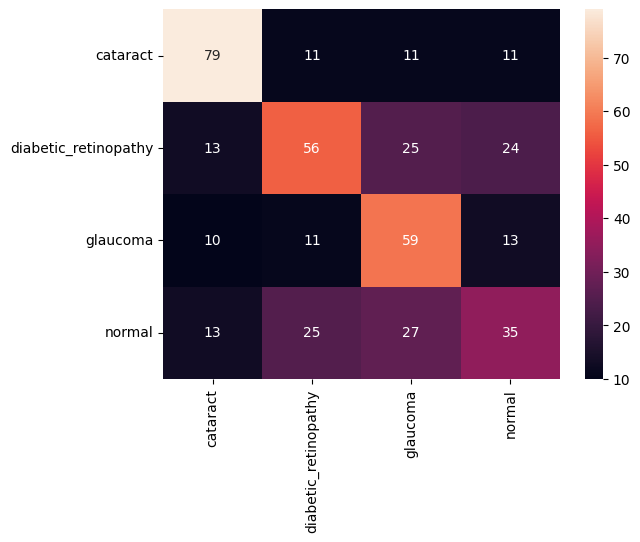

AdaBoostClassifier
Best Parameters: {'learning_rate': 1.0, 'n_estimators': 200}
                      precision    recall  f1-score   support

            cataract     0.7778    0.1875    0.3022       112
diabetic_retinopathy     0.3377    0.8644    0.4857       118
            glaucoma     0.5800    0.3118    0.4056        93
              normal     0.3864    0.1700    0.2361       100

            accuracy                         0.3995       423
           macro avg     0.5205    0.3834    0.3574       423
        weighted avg     0.5190    0.3995    0.3605       423



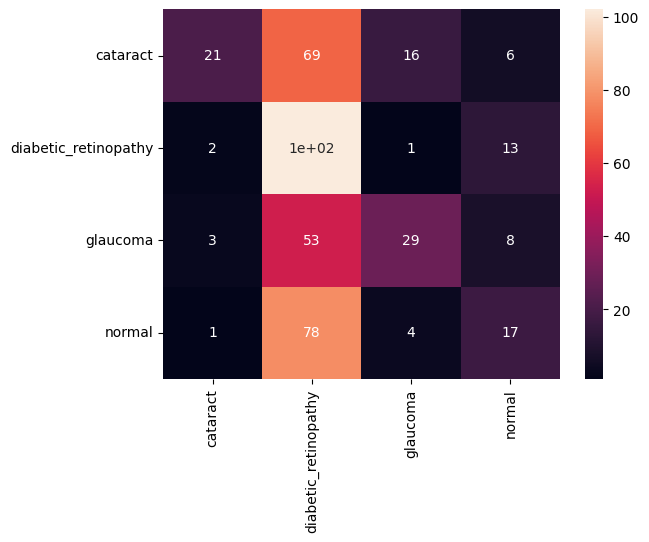

In [ ]:
del X_train, X_test, X_val
X_train, X_test, X_val = hist_dataset(converted_train_data, converted_test_data, converted_val_data)
evaluate(classifiers)

SVC
Best Parameters: {'C': 10, 'kernel': 'rbf'}
                      precision    recall  f1-score   support

            cataract     0.8000    0.6786    0.7343       112
diabetic_retinopathy     0.9512    0.6610    0.7800       118
            glaucoma     0.6000    0.6129    0.6064        93
              normal     0.6026    0.9100    0.7251       100

            accuracy                         0.7139       423
           macro avg     0.7385    0.7156    0.7114       423
        weighted avg     0.7516    0.7139    0.7167       423



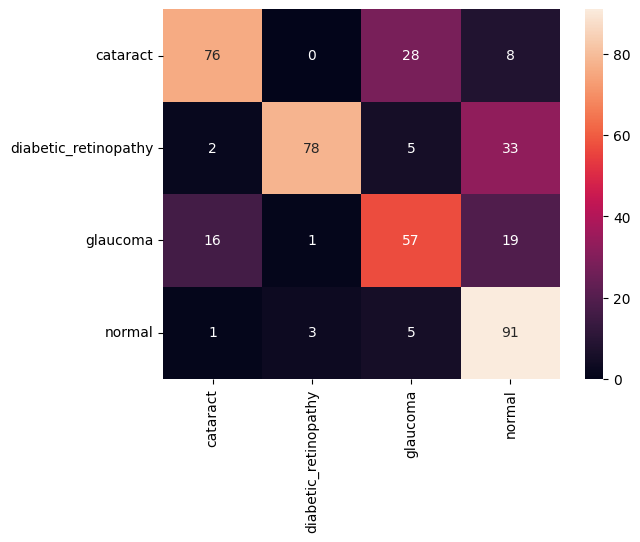

RandomForestClassifier
Best Parameters: {'max_depth': None, 'n_estimators': 100}
                      precision    recall  f1-score   support

            cataract     0.7864    0.7232    0.7535       112
diabetic_retinopathy     0.8641    0.7542    0.8054       118
            glaucoma     0.6211    0.6344    0.6277        93
              normal     0.6639    0.8100    0.7297       100

            accuracy                         0.7329       423
           macro avg     0.7339    0.7305    0.7291       423
        weighted avg     0.7428    0.7329    0.7347       423



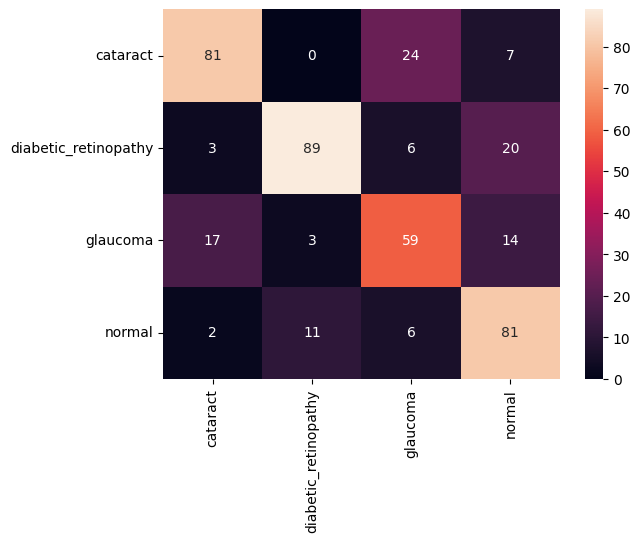

KNeighborsClassifier
Best Parameters: {'n_neighbors': 7, 'weights': 'distance'}
                      precision    recall  f1-score   support

            cataract     0.7843    0.7143    0.7477       112
diabetic_retinopathy     0.8750    0.7119    0.7850       118
            glaucoma     0.5900    0.6344    0.6114        93
              normal     0.6320    0.7900    0.7022       100

            accuracy                         0.7139       423
           macro avg     0.7203    0.7126    0.7116       423
        weighted avg     0.7309    0.7139    0.7174       423



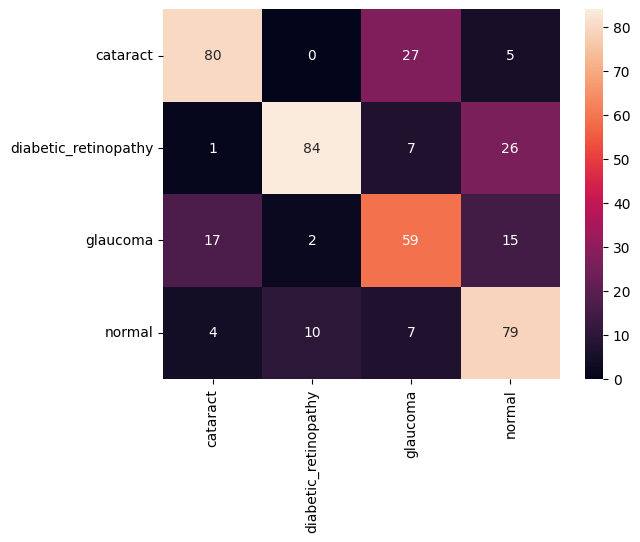

AdaBoostClassifier
Best Parameters: {'learning_rate': 1.0, 'n_estimators': 100}
                      precision    recall  f1-score   support

            cataract     0.6724    0.6964    0.6842       112
diabetic_retinopathy     0.8108    0.7627    0.7860       118
            glaucoma     0.5122    0.4516    0.4800        93
              normal     0.6754    0.7700    0.7196       100

            accuracy                         0.6785       423
           macro avg     0.6677    0.6702    0.6675       423
        weighted avg     0.6765    0.6785    0.6761       423



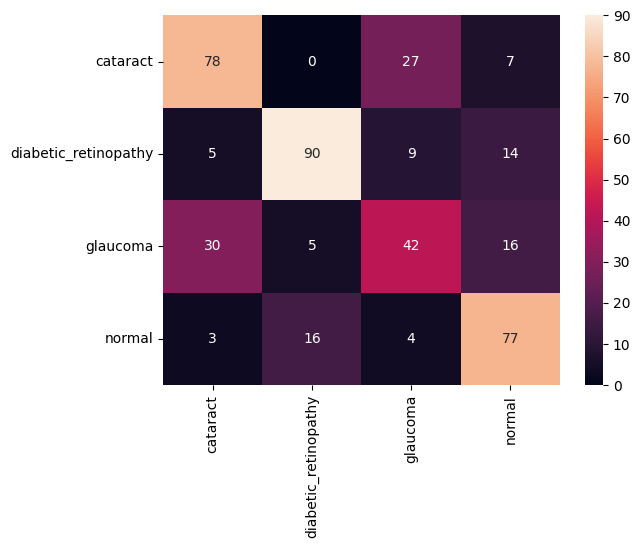

In [ ]:
del X_train, X_test, X_val
X_train, X_test, X_val = lbp_dataset(converted_train_data, converted_test_data, converted_val_data)
evaluate(classifiers)

In [ ]:
rf_param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
knn_param_grid = {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}
adaboost_param_grid = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1.0]}

classifiers = [
    (RandomForestClassifier(), rf_param_grid),
    (KNeighborsClassifier(), knn_param_grid),
    (AdaBoostClassifier(), adaboost_param_grid)
]

In [ ]:
del X_train, X_test, X_val
X_train, X_test, X_val = sobel_dataset(converted_train_data, converted_test_data, converted_val_data)
evaluate(classifiers)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END ....................max_depth=None, n_estimators=50; total time=  23.2s
[CV] END ....................max_depth=None, n_estimators=50; total time=  23.2s
[CV] END ....................max_depth=None, n_estimators=50; total time=  24.0s
[CV] END ...................max_depth=None, n_estimators=100; total time=  46.5s
[CV] END ...................max_depth=None, n_estimators=100; total time=  47.3s


KeyboardInterrupt: 